In [1]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

DATA_ROOT = "C:\\Users\\Student\\Desktop\\Kamilio\\Br35H"
IMG_SIZE = 128

Tensorflow recognized 1 GPUs


# Dataset loading functions

In [2]:
import os
import albumentations as A
AUTOTUNE = tf.data.AUTOTUNE
from functools import partial

transforms = A.Compose([
    A.Affine(scale = (2, 2), keep_ratio=True, p=1)
])

def get_classes(dataset_name):
    #TODO add functionality to pop error if classes in data splits do not match
    class_names = os.listdir(os.path.join(DATA_ROOT, dataset_name, "train"))
    class_names = [int(name) for name in class_names]
    class_names.sort()
    class_names = [str(name) for name in class_names]
    print(class_names)
    return class_names


def get_classes_dict(dataset_name):
    class_names = get_classes(dataset_name)
    class_names_dict = {}
    for class_name in class_names:
        image_sample_name = os.path.basename(glob.glob(os.path.join(DATA_ROOT, dataset_name, "train", str(class_name),'*'))[0])
        class_names_dict[str(class_name)] = image_sample_name.split('_')[1]
    return class_names_dict

def get_classes_dict_empty_lists(dataset_name):
    class_names = get_classes(dataset_name)
    class_names_dict = {}
    for class_name in class_names:
        class_names_dict[str(class_name)] = []
    return class_names_dict

def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    # TODO: pass CLASS_NAMES as function parameter
    one_hot = parts[-2] == CLASS_NAMES
    # Integer encode the label
    return int(one_hot)

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    return img

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    # Resize and norm the image
    aug_img = tf.image.resize(aug_img, size=[IMG_SIZE, IMG_SIZE])
    return aug_img

def apply_transformations(image):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img

def process_path(file_path, use_augmentations: bool):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    image = tf.io.read_file(file_path)
    image = decode_img(image)
    image = tf.cast(image/255, tf.float32)
    if use_augmentations:
        image = apply_transformations(image)
    return image, label

def load_dataset(dataset_name:str, split_type: str, use_transformations: bool, mini_batch_size: int):
    global CLASS_NAMES
    CLASS_NAMES = get_classes(dataset_name)
    dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{dataset_name}\\{split_type}\\*\\*", shuffle=False)
    dataset = dataset.shuffle(len(dataset), reshuffle_each_iteration=False)
    dataset = dataset.map(partial(process_path, use_augmentations=use_transformations), num_parallel_calls=AUTOTUNE).batch(mini_batch_size)
    return dataset

# Model initialization functions

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers

def get_initial_weights_type(imagenet_pretrained_backbone: bool):
    if imagenet_pretrained_backbone:
        weights='imagenet'
    else:
        weights=None
    return weights

def rebuild_top(model, class_count: int, top_dropout_rate: float = 0):
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization(name='batch_normalization')(x)
    if top_dropout_rate != 0:
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(class_count, activation="softmax", name="pred")(x)
    return outputs

def build_EffNetB0(class_count: int, imagenet_pretrained_backbone: bool, top_dropout_rate: float = 0):
    
    weights_type = get_initial_weights_type(imagenet_pretrained_backbone)
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=weights_type)
    outputs = rebuild_top(model, class_count, top_dropout_rate)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetB0')
    print("EffNet0 model build successfull")
    
    return model

def build_EffNetB3(class_count: int, imagenet_pretrained_backbone: bool, top_dropout_rate: float = 0):
    
    weights_type = get_initial_weights_type(imagenet_pretrained_backbone)
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights=weights_type)
    outputs = rebuild_top(model, class_count, top_dropout_rate)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetB3')
    print("EffNet3 model build successfull")
    
    return model

def build_EffNetB5(class_count: int, imagenet_pretrained_backbone: bool, top_dropout_rate: float = 0):
    
    weights_type = get_initial_weights_type(imagenet_pretrained_backbone)
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB5(include_top=False, input_tensor=inputs, weights=weights_type)
    outputs = rebuild_top(model, class_count, top_dropout_rate)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetB5')
    print("EffNet5 model build successfull")
    
    return model

def build_model(class_count: int, imagenet_pretrained_backbone: bool, architecture: str,  top_dropout_rate: float = 0):
    if architecture == "EffNetB0":
        model = build_EffNetB0(class_count, imagenet_pretrained_backbone, top_dropout_rate)
    elif architecture == "EffNetB3":
        model = build_EffNetB3(class_count, imagenet_pretrained_backbone, top_dropout_rate)
    elif architecture == "EffNetB5":
        model = build_EffNetB5(class_count, imagenet_pretrained_backbone, top_dropout_rate)
    else:
        raise Exception(f"Specified model architecture is not available")
        
    return model




# Load dataset

In [4]:
dataset_name = "data_v1.0.0"

map_dict = {'0': 'non-tumorous', '1': 'tumorous'}
sample_dict = {'0': [], '1': []}

ds = load_dataset(
                  dataset_name = dataset_name, 
                  split_type = "train", 
                  use_transformations = False, 
                  mini_batch_size = 1)

['0', '1']


# Load downstream ImageNet or SSL pretrained model

## ImageNet pretrained

In [ ]:
model = build_model(
                    class_count = 2, 
                    imagenet_pretrained_backbone = True,
                    architecture = 'EffNetB0',
                    top_dropout_rate = 0.2)

downstream_model_version = "model_v3.0.4"
model.load_weights(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\Downstream_v3\\{downstream_model_version}\\checkpoint")

## SSL pretrained

In [5]:
downstream_model_version = "model_v2.10.20"
model = tf.keras.models.load_model(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\Downstream_v2\\{downstream_model_version}")

# Modify model to output the feature vector

In [6]:
# Reinitializing dense classification layer
inputs = model.input
x = model.layers[-5].output
x_GAP = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization(name='batch_normalization')(x_GAP)
top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(2, activation="softmax", name="pred")(x)

model_GAP = tf.keras.Model(inputs, x_GAP)

# Generate feature matrix (collumns - feature embedings, rows - features for images)

In [ ]:
iterator=iter(ds)
y_gt = []
deep_features_list = []
for _ in range(len(ds)):
    sample = next(iterator)
    deep_features = model_GAP.predict(sample[0])
    label = tf.math.argmax(sample[1], axis=1).numpy()[0]
    y_gt.append(str(label))
    deep_features_list.append(list(deep_features[0]))

features = np.array(deep_features_list)

# PCA for feature embedings

In [8]:
from sklearn.decomposition import PCA
import pandas as pd

In [9]:
print(features.shape)
pca = PCA()
pca.fit(features)
print(pca.components_.shape)
first_component = pca.components_[:,1]
second_component = pca.components_[:,2]

(601, 1280)
(601, 1280)


In [10]:
df = pd.DataFrame([first_component, second_component, y_gt])
df = df.T
df.columns = ['first', 'second', 'label']
df.head()

,first,second,label
0,0.00041,0.000019,1
1,-0.000391,-0.000018,0
2,0.000006,-0.000036,1
3,-0.000016,-0.000002,0
4,0.000272,0.000033,1


Text(0, 0.5, 'second component')

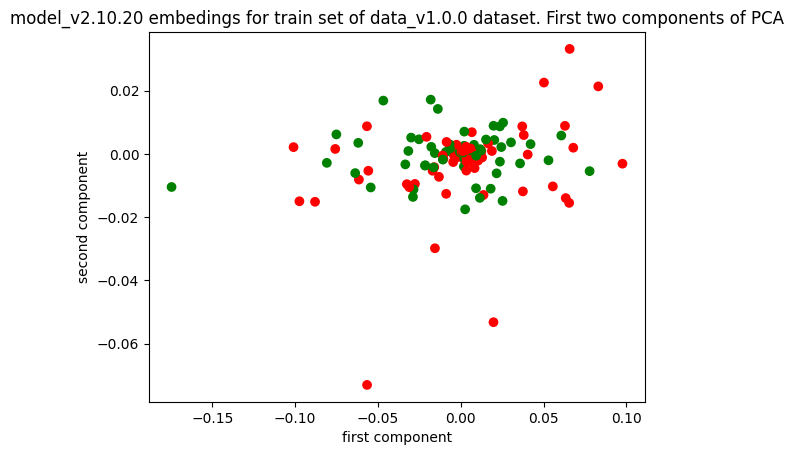

In [11]:
colors = {'0':'red', '1':'green'}
plt.scatter(df['first'], df['second'], c=df['label'].map(colors))
plt.title(f"{downstream_model_version} embedings for train set of {dataset_name} dataset. First two components of PCA")
plt.xlabel('first component')
plt.ylabel('second component')